# Purpose: To build out the skeleton Pseudo Code for this project

__For now__: Moving my notes from my one one one with Elizabeth and will build out more in the next few days

1. Input .csv from experimental team to describe data
2. CSV pulls the proper images from NDP (or wherever best storage location is determined to be)
2a. There needs to be some integration with NDP to break the image into chunks with the appropriate zoom and then provide the original slice with locations of test and training images printed out.
2b. I think to do this we are going to have to register the image to some kind of atlas... or somethign to determine regions so that the code can grab pictures
3. Images need to be split
3a. Regionally
3b. Test Groups
3c. Into Small enough sizes for most efficient processing by package
3d. Magifications
4. Threshold and segment
4a. Ifthresholds (for general object identification) [July]
4b. + Skeletonization (for specific highly branched morphometric analysis) [Robin]
5. Split data into testing and training groups
6. Shape factor analysis on both models (before ML model)
7. Feed 4(1) and 4(2) separately to modified VAMPIRE package to build models
8. Store created models
9. Test models with testing data sets
10. Data output
11. Comprehensive CSV for optional additional analysis
12. Data Visualization
13. Save all data into some storage location (Google Drive?)


Other Notes: 
1. Modified VAMPIRE package: Worth forking the Wirtz lab repository now and building on by ourselves possibly – adding that fork to our repository - COMPLETE
2. Want a repository that works through Binder? Preferably so the Neonatalogy lab can do this straight through a web interface
3. Along with outputs want to output the variables used for all of the steps on days that experiments were run with an easy print out maybe for lab notebook storage? (A way to integrate the electronic lab notebook I want to get more fine tuned for our lab with a standard lab notebook - and provide some under the hood knowledge for Neonatology)

4. Add in an optimization step for what size of image is sufficient for cropping down the whole scan images 
5. Including an analysis before creating that analysis that selects the best # of shape modes and #coordinate points – maybe we could reach out the Denis Wirtz lab about this or build in our own integration



Current Goal:

1. Get a bunch of images from a slice of the ferret brain
2. Put them in a folder
3. Perform thresholding within the Jupyter Notebook
3. Integrate vampire into the Jupyter Notebook
4. Run those images and get an output within the notebook or specific folder (which should will need a results output)
5. Save all of this information to some results folder
6. See if it works in binder

Next Goals:
1. Build out ifthresholds more for immunohistochemistry stains
2. Build in NDP regional registration and automatic image breakdown
3. Integrate Google Drive
4. New visualizations based on what came from paper
5. Statistics possibly with Rthon
6. Speed up any slow processes with Cython
7. Integrate ifThresholds to pick and perform the best thresholding (or integrate a step to say whether this needs to be done or not)

*Step 1: Import necessary packages*

If import shows ERROR:

"Could not find Java JRE compatible with x86_64 architecture" then close out of jupyter lab and exit that terminal window. Start a new window and before accessing Jupyter Lab fix the Java home

http://www.sajeconsultants.com/how-to-set-java_home-on-mac-os-x/?utm_source=rss&utm_medium=rss&utm_campaign=how-to-set-java_home-on-mac-os-x

' export JAVA_HOME=/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home'

' echo $JAVA_HOME'

In [77]:
import numpy as np
import os

from skimage import io
from skimage import filters
from skimage import measure
from skimage import morphology
from skimage import segmentation
from skimage import color

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from PIL import Image

import cellprofiler.modules.threshold as cpmthreshold
import cellprofiler.modules.identifyprimaryobjects as cpm_ipo
import cellprofiler_core
import cellprofiler_core.workspace as workspace
import cellprofiler_core.image as cpimage
import cellprofiler_core.object as cpobject

*Step 2: User Inputs*

In [3]:
data_folder = '/Users/hhelmbre/Desktop/fiberf_data'
image_file_type = '.jpg'

*Step 3: Threshold and Segment Images*

Step 3a: Import and threshold images from 'data_folder'

In [4]:
image_list = os.listdir(data_folder)
image_list = np.asarray(image_list)

*Removing anything that isn't an image from the image list*

In [5]:
k=0
for images in image_list:
    if image_file_type in str(images):
        k+=1
    else:
        image_list = np.delete(image_list, (k), axis=0)

practice images to figure out loop below

In [6]:
practice_image = image_list[1]
practice_image = io.imread(str(data_folder + '/' + practice_image))
practice_image.shape

(614, 1419, 3)

In [7]:
practice_image1 = practice_image[:,:,0]
practice_image2 = practice_image[:,:,1]
practice_image3 = practice_image[:,:,2]

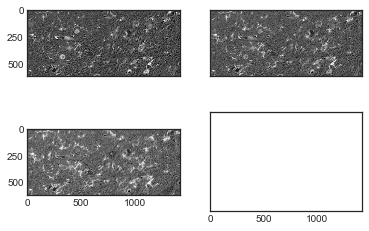

In [8]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0,0].imshow(practice_image1)
ax[0,1].imshow(practice_image2)
ax[1,0].imshow(practice_image3)

#Need to do work in future to figure out which of these is best to use? or whether we use more than one

*back to what will be the main code*

In [159]:
name = str(data_folder + '/' + image_list[1])
im = io.imread(name)
im = im[:,:,2]
threshold = filters.threshold_otsu(im)
binary = morphology.closing(im < threshold, morphology.square(5))
#cleared = segmentation.clear_border(binary)
label_image = measure.label(binary, return_num=False, connectivity=2)
#image_label_overlay = color.label2rgb(label_image, image=im, bg_label=0)



binary2 = morphology.remove_small_objects(label_image, min_size=500, connectivity=1, in_place=True)


In [164]:
props = measure.regionprops_table(label_image, properties= ('centroid', 'area', 'major_axis_length', 'minor_axis_length'))

In [166]:
import pandas as pd
pd.DataFrame(props)

ModuleNotFoundError: No module named 'pandas'

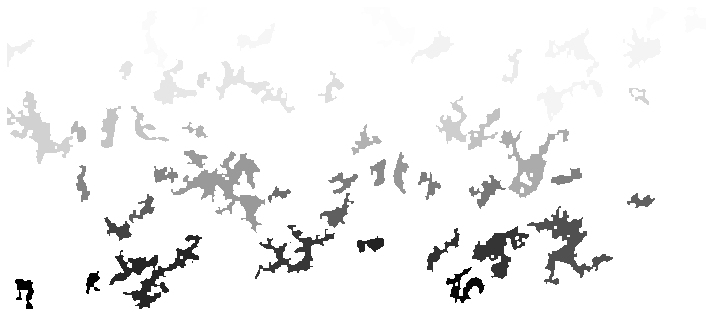

In [160]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(binary2)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [13]:
#Creating a folder for the new tresholded images
os.mkdir(str(data_folder + '/' + 'threshold_applied_images'))

#Looping through all images in list (this task should be put to multiple CPUs in future if a large data set)
for images in image_list:
    name = str(data_folder + '/' + images)
    im = io.imread(name)
    im = im[:,:,2]
    threshold = filters.threshold_otsu(im)
    binary = im > threshold
    binary2 = morphology.remove_small_objects(binary, min_size=1000, connectivity=2, in_place=True)
    
    # Saving the thresheld images to their own folder with modified names
    im_to_save = Image.fromarray(binary2)
    new_name = str(data_folder + '/' + 'threshold_applied_images' + '/' + images)
    new_name = new_name.replace('.jpg','_threshold.jpg')
    im_to_save.save(new_name)

# Step 3: Vampire with Desktop Cell Profiler Steps

# Step 4: Cell Profiler Steps 

What I ended up doing to get it working to this point:
1. Created a conda virtual environment
2. Conda installed all the necessary pacakges accordign to the setup.py file on the CellProfiler github
3. Then used the instructions to pip install a github package from the "actual" but useless Cell Profiler install instructions on their wiki
4. the secret! for success is that when using Java you have to change the home directory to where the JDK java install was actually put and then within there to the JVM folder> contents> home. 

I do not think this is permanent. I believe I have to do it every time unless I officially change the path.

next steps: Figure out how to actually use cell profiler without the GUI for what we need it for.

6-7-2020: with the daily Java Home restate it seems to be working. The next challenge is to recreate what we have been doing in the GUI within this notebook so its high throughput

*Steps From the Actual GUI*
1. Images Module
2. Metadata Module
3. Names and Types Module
4. Groups Module
5. Indentify Primary Objects (nuclei) - This may not be possible unless there is a coordinate system in NDP
6. Measure Object Size Shape
7. Convert Objects to Image
8. SaveImages
9. Identify Secondary Objects
10. Measure Object Size Shape
11. ConvertObjectstoImage
12. SaveImages
13. ExporttoSpreadsheet

6/16/2020 update:

I tried using the cellprofiler desktop with my own thresholdinga dn it si still bad. Clearly the program isn't meant for my type of thresholding? or I don't use the program well enough? Maybe it doesn't work in tissue. i have to make the decision between where I think my time should go (I am super frustrated lol)

*Cell Profiler Inputs*

In [9]:
#User input pipeline to try and get this thing working
pipeline = '/Users/hhelmbre/Desktop/vampire_experiments/Supplementary\ files/Workflow\ for\ VAMPIRE.cppipe'

*Create the CellProfiler Workspace*

In [11]:
#initializing that measurements equals none (reads incorrectly if done in workspace below)
measurements=None

In [24]:
#ImageSet = workspace.Workspace.image_set
#ObjectSet = workspace.Workspace.object_set

ImageSet = cpimage._image_set.ImageSet
ObjectSet = cpobject._object_set.ObjectSet

In [25]:

workspaced = workspace.Workspace(pipeline, cpm_ipo, ImageSet, ObjectSet, measurements, image_list, frame=None, create_new_window=False, outlines=None)

*Apply a threshold - this may be able to be done during IdentifyPrimaryObjects so may be deleted*

In [21]:
threshold = cpmthreshold.Threshold()

In [22]:
threshold.apply_threshold()

TypeError: apply_threshold() missing 2 required positional arguments: 'image' and 'threshold'

*Identifying the nuclei of pictures*

In [31]:
nuclei_identification = cpm_ipo.IdentifyPrimaryObjects()
nuclei_identification.run(workspaced)

TypeError: get_image() missing 1 required positional argument: 'name'

*Trying something different from (https://github.com/CellProfiler/notebooks/blob/master/cellprofiler_demo.ipynb)*

In [15]:
#Edited these from their notebook tutorial to be 'cellprofiler_core' instead of 'cellprofiler' only
import cellprofiler_core.image
import cellprofiler_core.measurement
import cellprofiler_core.object
import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.workspace

In [16]:
def run_pipeline(pipeline_filename, image_dict):
    cellprofiler_core.preferences.set_headless()
    
    # Create and load the pipeline
    pipeline = cellprofiler_core.pipeline._pipeline.Pipeline()
    pipeline.load(pipeline_filename)
    
    # Create the image set, and add the image data
    image_set_list = cellprofiler_core.image.ImageSetList()
    image_set = image_set_list.get_image_set(0)
    for image_name, input_pixels in image_dict.items():
        image_set.add(image_name, cellprofiler_core.image.Image(input_pixels))
        
    # Persist the object set here (for now, see workspace TODO)
    object_set = cellprofiler_core.object.ObjectSet()

    # We can only run one group -- set the group index to 1.
    measurements = cellprofiler_core.measurement.Measurements()
    measurements.group_index = 1

    # Run the modules!
    for module in pipeline.modules():
        # Yes, we really do have to create a new workspace for each module
        # because the module attribute is required. Go team.
        workspace = cellprofiler_core.workspace.Workspace(
            image_set=image_set,
            image_set_list=image_set_list,
            measurements=measurements, 
            module=module,
            object_set=object_set, 
            pipeline=pipeline
        )
        
        module.prepare_run(workspace)
        module.run(workspace)
        module.post_run(workspace)
    
    # The workspace object has access to the measurements
    # and the image set/image set list which can be used
    # to use/view/store/whatever output data.
    return workspace


In [17]:
def objects2df(measurements, objects_name):
    features = measurements.get_feature_names(objects_name)
    
    n_features = len(features)
    n_objects = int(measurements.get_measurement("Image", "Count_{}".format(objects_name)))
    
    data = np.empty((n_objects, n_features))
    
    for feature_idx, feature in enumerate(features):
        data[:, feature_idx] = measurements.get_measurement(objects_name, feature)
    
    return pd.DataFrame(
        data=data,
        index=np.arange(1, n_objects + 1),
        columns=features
    )

In [22]:
# This should match what NamesAndTypes would produce.
images = {
    #"OrigBlue": skimage.io.imread("data/images/01_POS002_D.TIF"),
    "OrigGreen": io.imread(str('/Users/hhelmbre/Desktop/fiberf_data/' + image_list[0])),
    #"OrigRed": skimage.io.imread("data/images/01_POS002_R.TIF")
}

pipeline_filename = "/Users/hhelmbre/Downloads/ExampleHuman/ExampleHuman.cppipe"

*Checking something for javabridge*

In [20]:
import javabridge
import bioformats
import os
javabridge.start_vm(class_path=bioformats.JARS)
classpath = javabridge.JClassWrapper('java.lang.System').getProperty('java.class.path')
#for path in classpath.split(os.pathsep):
    #print (str(("exists: " if os.path.isfile(path) else "missing: ") + path))


*The above gets the session to run and brings up a new error*

*back to it*

In [28]:
workspace = run_pipeline(pipeline_filename, images)

JavaException: org.cellprofiler.imageset.ImageFile

In [27]:
df = objects2df(workspace.measurements, "Nuclei")
df.head()

NameError: name 'workspaced' is not defined

*Step 5: Train and Test Split Images*

*Step 6: Build model using VAMPIRE*

*Step 7: Apply model using VAMPIRE*

*Step 8: New visualization of VAMPIRE data*

- This should probably be built into VAMPIRE and not just into this notebook - think about this for the future